In [1]:
import scipy.optimize
import xarray as xr
import pandas as pd
import matplotlib
import numpy as np
import cartopy.mpl.ticker as cticker
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import metpy
import scipy.stats as sts
from glob import glob
import sys
import cftime
import datetime
import warnings
import isca_tools
from isca_tools import cesm
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.base import round_any
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, dry_profile_temp, moist_profile
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure
from isca_tools.utils.moist_physics import sphum_sat
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
from isca_tools.cesm.load import jasmin_archive_dir, jasmin_surf_geopotential_file
import copy
import os

print(os.getcwd())
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/Users/joshduffield/Documents/StAndrews/Isca/jobs/theory_lapse


In [2]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7

plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

In [48]:
data_dir = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/3_hour/hottest_time'
exp_name = ['pre_industrial', 'co2_2x']
co2_vals = [1, 2]
n_exp = len(exp_name)
ds = [xr.load_dataset(os.path.join(data_dir, exp_name[i], 'output.nc')) for i in range(n_exp)]
ds = xr.concat(ds, dim=xr.DataArray(co2_vals, dims="co2", coords={"exp_name": ("co2", exp_name)}))

In [51]:
invariant_data_path = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/input_data/fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc'
lsm = (xr.open_dataset(invariant_data_path).LANDFRAC > 0)
lsm = lsm.reindex_like(ds, method="nearest", tolerance=0.01)

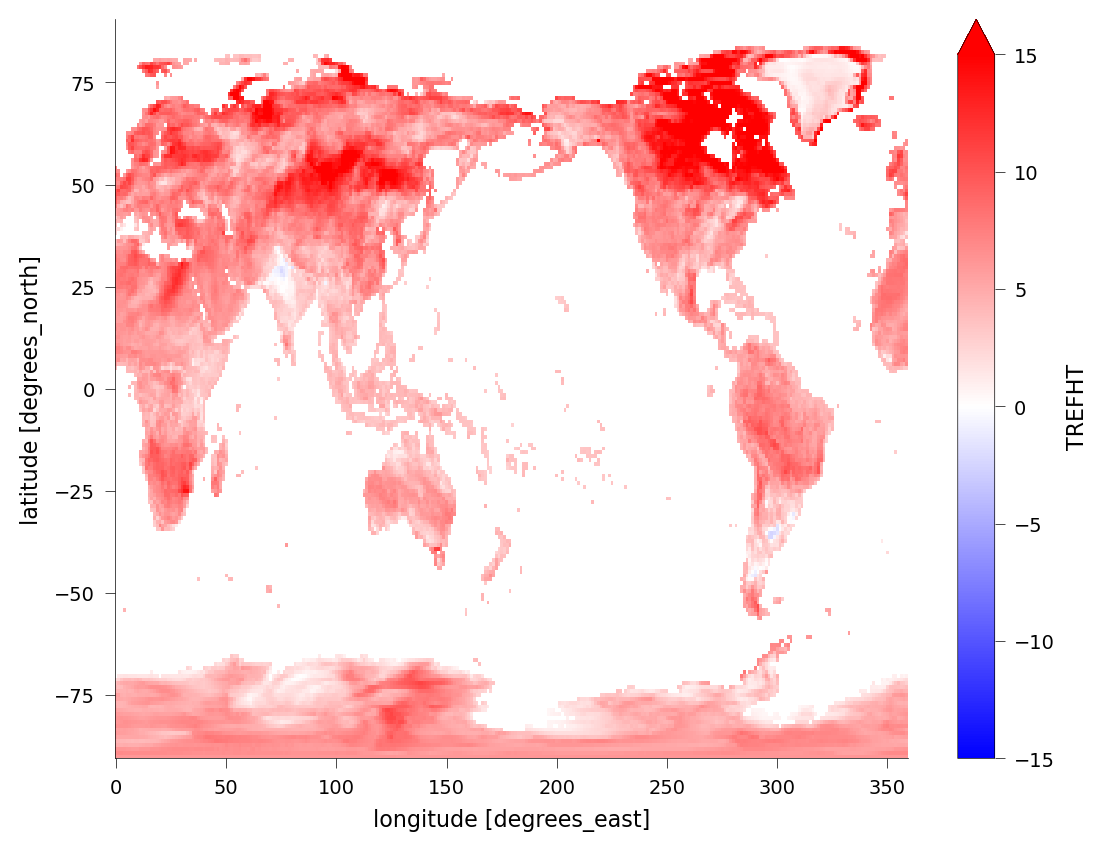

In [55]:
(ds.TREFHT.isel(co2=1)-ds.TREFHT.isel(co2=0)).where(lsm).plot(vmin=-15, vmax=15, cmap='bwr')

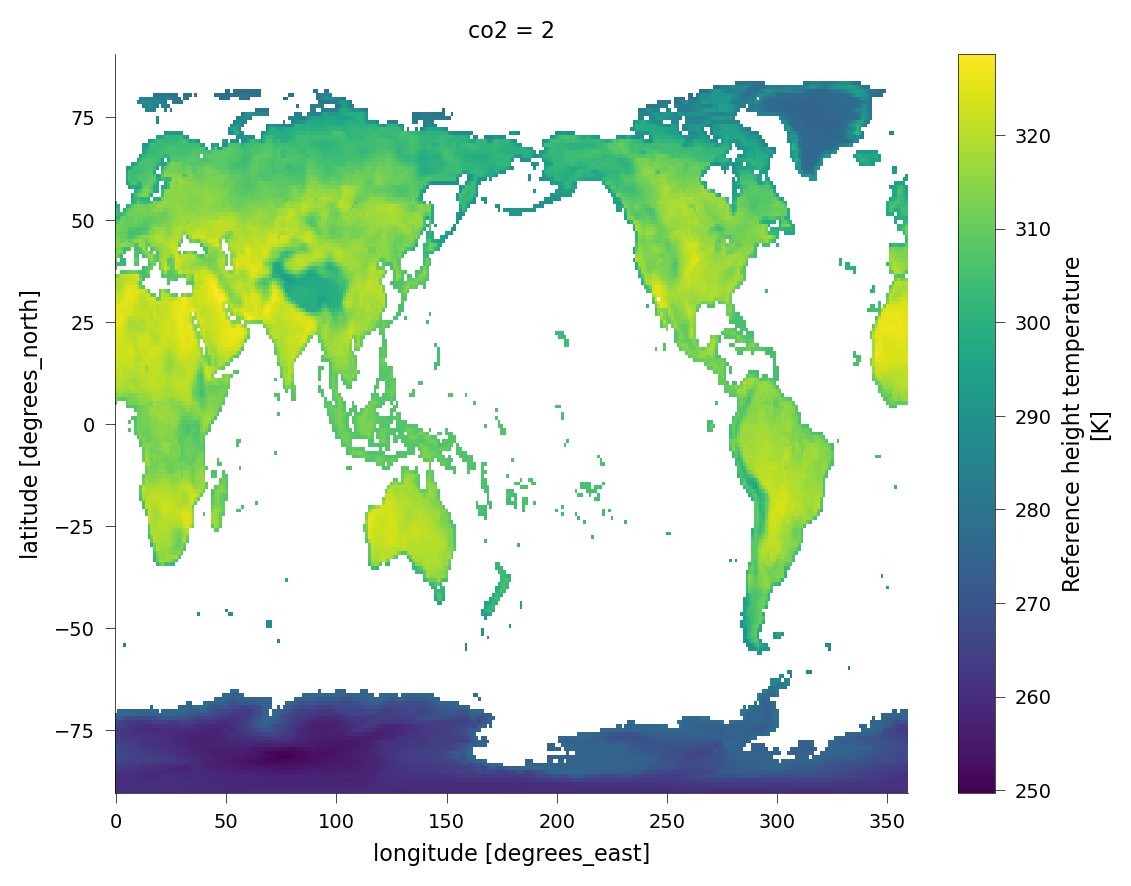

In [78]:
ds.isel(co2=1).TREFHT.where(lsm).plot()

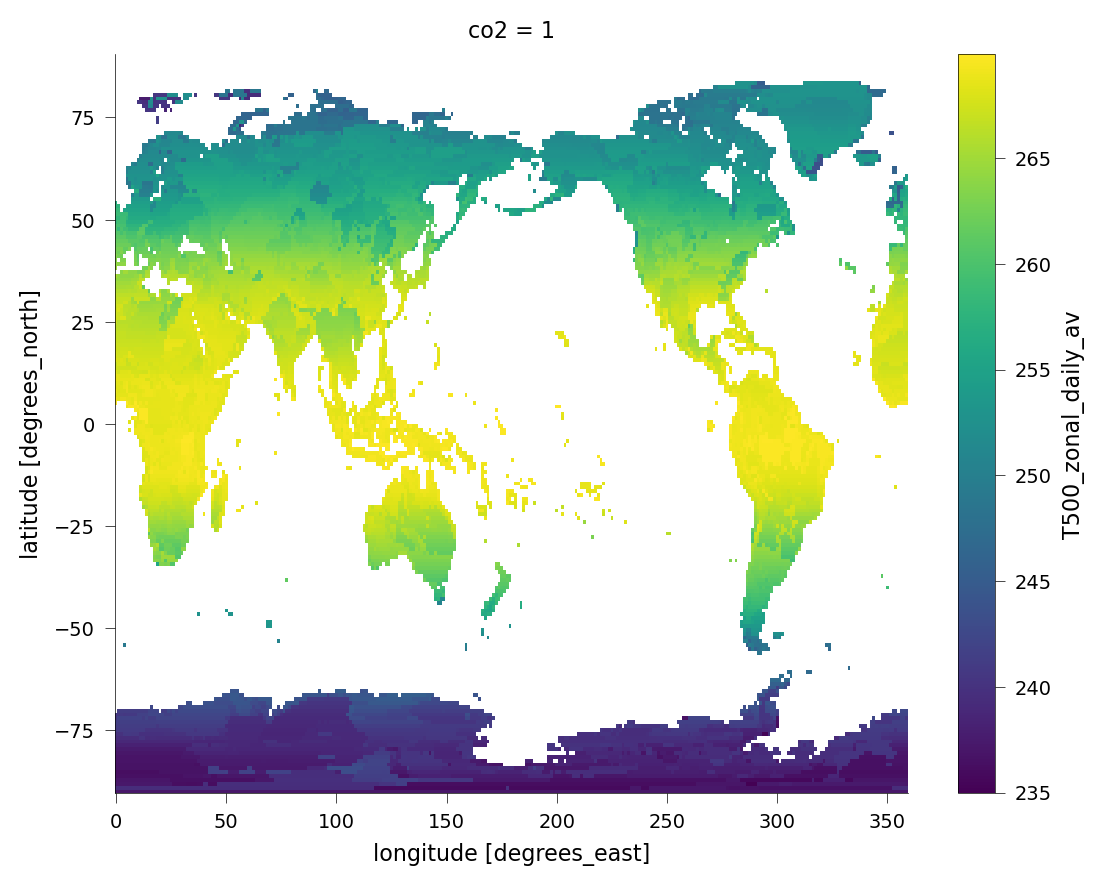

In [83]:
# zonal, daily av T500 at time of max TREFHT - this closely corresponds to day of year below
ds.isel(co2=0).T500_zonal_daily_av.where(ds.isel(co2=0).time_max.dt.floor('D') == ds.time.dt.floor('D')).max(dim='time').where(lsm).plot()

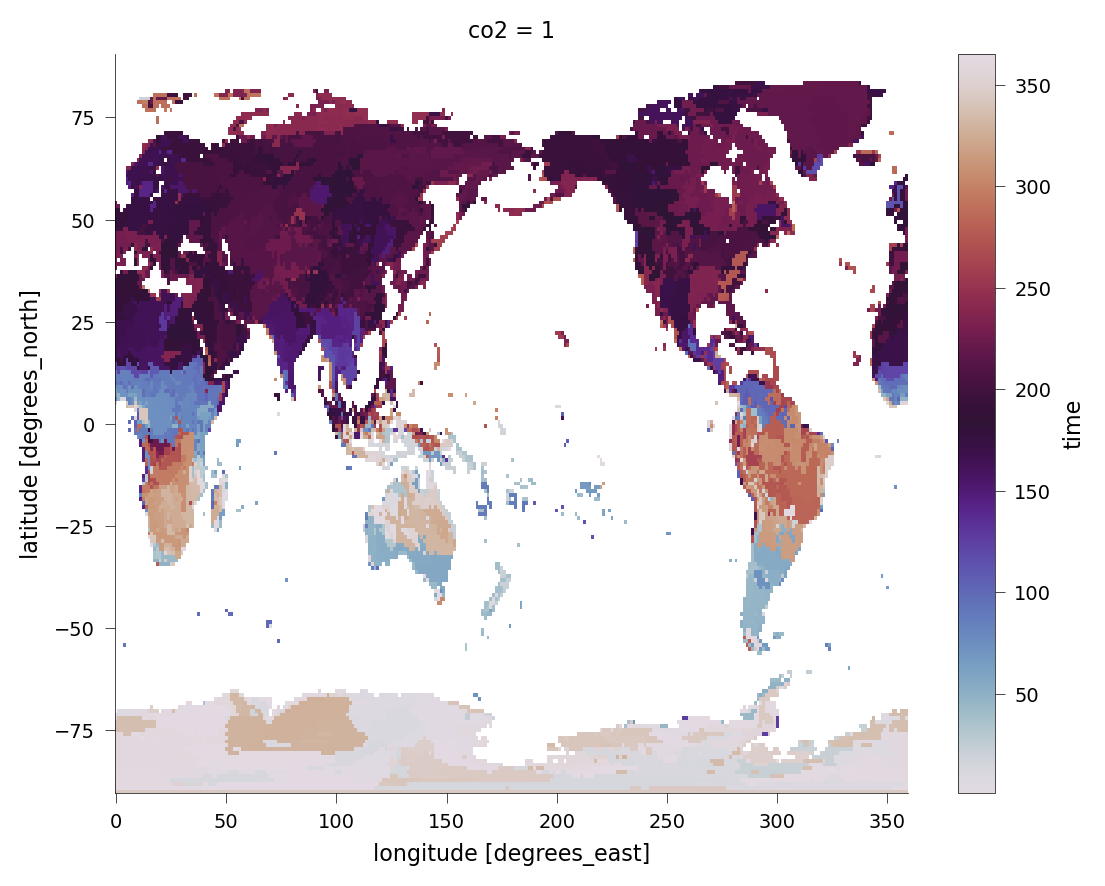

In [82]:
ds.time_max.dt.dayofyear.isel(co2=0).where(lsm).plot(cmap='twilight')